In [1]:
import xarray as xr
import numpy as np
import scipy as sc
import sklearn as skl
import skimage as ski
import pysteps
from pysteps.verification.spatialscores import fss, intensity_scale
from pysteps.verification.salscores import sal
from pysteps.verification.detcontscores import det_cont_fct
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import copy
from matplotlib import colors
import cartopy.crs as ccrs
import wrf

Pysteps configuration file found at: /work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/pysteps/pystepsrc



In [2]:
event_ID=0
def region_sel(event_ID):
    ##% REGION SELECTION
    if event_ID==0:
        ###USA
        year=2020; month=np.arange(3,10); 
        latslice=slice(20,50); lonslice=slice(250,300)
        lon_conv=False
        flag='USA'
    elif event_ID==1:
        ###ARGENTINA
        year=2020; month=(9,10,11,12,1,2)
        latslice=slice(-40,-25); lonslice=slice(290,310)
        lon_conv=False
        flag='ARG'
    elif event_ID==2:
        ###AUSTRALIA
        year=2020; month=(9,10,11,12,1,2)
        latslice=slice(-35,-20); lonslice=slice(140,155)
        lon_conv=False
        flag='AUS'
    elif event_ID==3:
        ###CHINA
        year=2020; month=np.arange(4,10)
        latslice=slice(20,35); lonslice=slice(100,120)
        lon_conv=False
        flag='CHN'
    elif event_ID==4:
        ###EUROPE
        year=2020; month=np.arange(4,10)
        latslice=slice(35,55); lonslice=slice(-10,30)
        lon_conv=True
        flag='EUR'
    return year, month, latslice, lonslice, lon_conv, flag

year, month, latslice, lonslice, lon_conv, flag = region_sel(event_ID)

In [3]:
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/'
soundpath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/SOUNDINGS/'
models=['graphcast_','graphcast-oper','pangu_','pangu-oper','fcnv2_dawn','ifs']
references=['era','ifs_init']
figpath='/users/mfeldman/figs/scores/'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black

In [4]:
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020_'+flag+'/'
models=['graphcast_','graphcast-oper_','pangu_','pangu-oper_','ifs_','sfno_','sfno-oper_']#'fcnv2_dawn','ifs']
labels=['graphcast','graphcast-oper','pangu','pangu-oper','ifs','sfno','sfno-oper']
references=[flag+'_era5_convseason_2020.nc',flag+'_init_convseason_2020.nc']
rlabels=['era5','ifs-init']
#figpath='/users/mfeldman/figs/season/'+flag+'_'
figpath='/users/mfeldman/figs/pub/'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black
c7='#f3322f' #red
cs=[c2,c1,c3,c7,c6,c5,c4]#c5
###CASE VIS
event_ID==0
year, month, latslice, lonslice, lon_conv, flag = region_sel(event_ID)
savepath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/season_2020_'+flag+'/'
year=2020; month=4; day=np.arange(12,14,1)
latslice=slice(27,40);lonslice =slice(260,285)


In [5]:
dp2 = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/case_2020_USAtor/'
era_ref=xr.open_dataset(dp2+'USA_tor_2020_era.nc').sortby('latitude').fillna(0)
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)

era_mod_cape=xr.open_dataset(dp2+'USA_tor_2020_cape_era5.nc').sortby('latitude').fillna(0)

cape1=era_ref.cape.values.flatten()
cape2=era_mod_cape.cape.values.flatten()
ind=np.where(cape2<200)
cape2 = np.delete(cape2,ind); cape1 = np.delete(cape1,ind)
ind=np.where(cape1<200)
cape2 = np.delete(cape2,ind); cape1 = np.delete(cape1,ind)
data = {'cape plevel': cape1,
        'cape mlevel': cape2}
dset=pd.DataFrame(data)


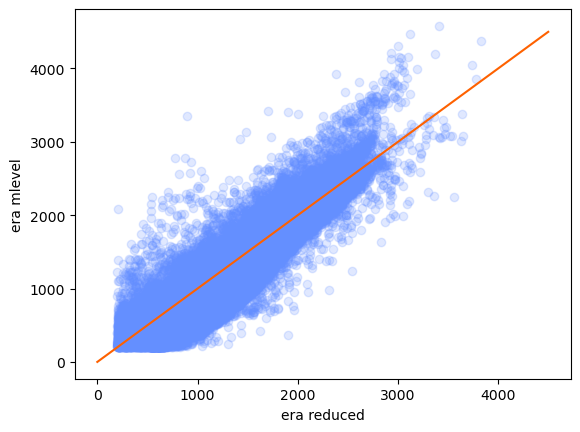

In [6]:
plt.scatter(cape1,cape2,alpha=0.2,c=c1)
plt.xlabel('era reduced')
plt.ylabel('era mlevel')
plt.plot(np.arange(4500),np.arange(4500),c=c4)
plt.show()

#era_inst=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps_era, ter_follow=False)

making kde-plot
formatting kdeplot


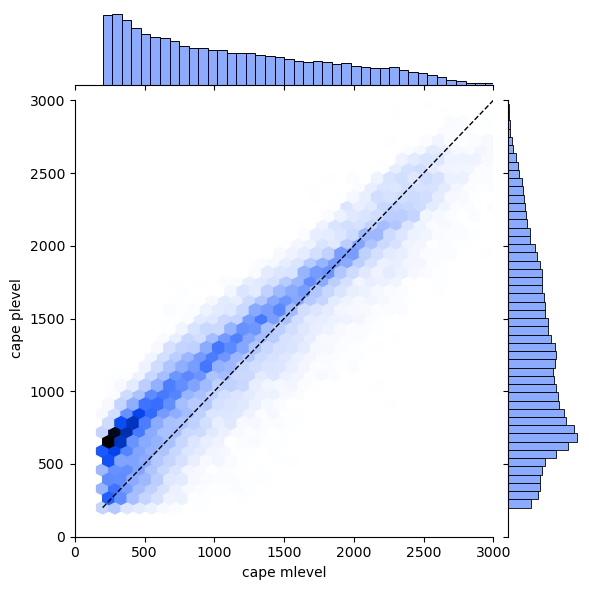

In [52]:
print('making kde-plot')
g=sns.jointplot(data=dset, x="cape mlevel", y="cape plevel", kind='hex', color=c1, 
                         xlim=(0,3000), ylim=(0,3000) )#levels=np.arange(0,1.1,0.1),, fill=True, alpha = 0.7
g.ax_joint.plot([200,3000], [200,3000], c='k', linewidth = 1, linestyle = '--')
print('formatting kdeplot')

# g.ax_joint.set_xlabel('0-6km shear [m s$^{-1}$]')
# g.ax_joint.set_ylabel('CAPE [J kg$^{-1}$]')
g.savefig(figpath+'era5_comp_kde.png')

In [7]:
stnames=['LAKE_CHARLES','JACKSON','SHREVEPORT','SLIDELL','BIRMINGHAM','FORT_WORTH']
from metpy.calc import specific_humidity_from_dewpoint
from metpy.units import units

fillen = len(glob(soundpath+'*'))
fill = {'station': np.zeros(fillen),
        'date_time': np.zeros(fillen),
        'lat': np.zeros(fillen),
        'lon': np.zeros(fillen),
        'height': np.zeros(fillen),
        'cape': np.zeros(fillen),
        'cin': np.zeros(fillen),
        'lcl': np.zeros(fillen),
        'lfc': np.zeros(fillen),
        'era_cape_mlevel': np.zeros(fillen),
        'era_cape_plevel': np.zeros(fillen)}

soundings=pd.DataFrame(fill)
a=0
b=0
for stname in stnames[:]:
    files=sorted(glob(soundpath+stname+'*'))
    for file in files[:]:
        data = pd.read_csv(file,sep=';')
        data = data.sort_values(by='pressure',ascending=True)
        soundings.station[a]=stname
        soundings.date_time[a]=data.time.values[0]
        soundings.lat[a]=data.latitude.values[0]
        soundings.lon[a]=data.longitude.values[0]
        soundings.height[a]=data.elevation.values[0]

        data['spec_hum']=specific_humidity_from_dewpoint(pressure=(data.pressure.values * units.hPa), dewpoint=(data.dewpoint.values * units.degC)).magnitude

        sound_inst=wrf.cape_2d(pres_hpa=data.pressure.values, tkel=data.temperature.values+273.3, qv=data.spec_hum.values, height=data.height.values, terrain=data.elevation.values[0], psfc_hpa=data.pressure.values[0], ter_follow=False)
        print(sound_inst)
        soundings.cape[a]=sound_inst[0].values
        soundings.cin[a]=sound_inst[1].values
        soundings.lcl[a]=sound_inst[2].values
        soundings.lfc[a]=sound_inst[3].values

        c = (a - (4*(b)))*2
        ilat1 = np.argmin(abs(era_ref.latitude.values - data.latitude.values[0]))
        ilon1 = np.argmin(abs(era_ref.longitude.values - data.longitude.values[0] - 360))
        ilat2 = np.argmin(abs(era_mod_cape.latitude.values - data.latitude.values[0]))
        ilon2 = np.argmin(abs(era_mod_cape.longitude.values - data.longitude.values[0]))
        soundings.era_cape_mlevel[a]=era_ref.cape[c,ilat1,ilon1].values
        soundings.era_cape_plevel[a]=era_mod_cape.cape[c,ilat2,ilon2].values
        
        a+=1
    b+=1
    print(c,ilat2,ilon2)

        

/tmp/ipykernel_676916/4216066724.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'LAKE_CHARLES' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  soundings.station[a]=stname
/tmp/ipykernel_676916/4216066724.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.date_time[a]=data.time.values[0]
/tmp/ipykernel_676916/4216066724.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2020-04-12' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  soundings.date_time[a]=data.time.values[0]
/tmp/ipykernel_676916/4216066724.py:28: SettingWithCopyWarning: 
A value is trying to be 

<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([ 241.84625391,   95.45392244, 1265.11566521, 3730.49178985])
Coordinates:
  * mcape_mcin_lcl_lfc  (mcape_mcin_lcl_lfc) <U5 'mcape' 'mcin' 'lcl' 'lfc'
Attributes:
    description:    mcape ; mcin ; lcl ; lfc
    units:          J kg-1 ; J kg-1 ; m ; m
    MemoryOrder:    
    _FillValue:     9.969209968386869e+36
    missing_value:  9.969209968386869e+36
<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([2009.03798081,   86.83760837,  379.92660349, 3325.77683532])
Coordinates:
  * mcape_mcin_lcl_lfc  (mcape_mcin_lcl_lfc) <U5 'mcape' 'mcin' 'lcl' 'lfc'
Attributes:
    description:    mcape ; mcin ; lcl ; lfc
    units:          J kg-1 ; J kg-1 ; m ; m
    MemoryOrder:    
    _FillValue:     9.969209968386869e+36
    missing_value:  9.969209968386869e+36
<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([2530.80752782,   41.68776395,  761.9636765 , 1348.9475777 ])
Coordinates:
  * mcape_mcin_lcl_lfc  (mcape_mci

/tmp/ipykernel_676916/4216066724.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.cape[a]=sound_inst[0].values
/tmp/ipykernel_676916/4216066724.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.cin[a]=sound_inst[1].values
/tmp/ipykernel_676916/4216066724.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.lcl[a]=sound_inst[2].values
/tmp/ipykernel_676916/4216066724.py:39: SettingWithCopyWarning: 
A

<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([           nan,            nan,  2103.58396945, 30737.        ])
Coordinates:
  * mcape_mcin_lcl_lfc  (mcape_mcin_lcl_lfc) <U5 'mcape' 'mcin' 'lcl' 'lfc'
Attributes:
    description:    mcape ; mcin ; lcl ; lfc
    units:          J kg-1 ; J kg-1 ; m ; m
    MemoryOrder:    
    _FillValue:     9.969209968386869e+36
    missing_value:  9.969209968386869e+36
6 49 80
<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([  13.84704778,           nan, 3480.62435285, 4739.82751306])
Coordinates:
  * mcape_mcin_lcl_lfc  (mcape_mcin_lcl_lfc) <U5 'mcape' 'mcin' 'lcl' 'lfc'
Attributes:
    description:    mcape ; mcin ; lcl ; lfc
    units:          J kg-1 ; J kg-1 ; m ; m
    MemoryOrder:    
    _FillValue:     9.969209968386869e+36
    missing_value:  9.969209968386869e+36
<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([1244.89919882,   80.73653896, 2089.88712475, 3252.00281677])
Coordinates:
  * mcape_mcin_lcl_lfc

/tmp/ipykernel_676916/4216066724.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.lat[a]=data.latitude.values[0]
/tmp/ipykernel_676916/4216066724.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.lon[a]=data.longitude.values[0]
/tmp/ipykernel_676916/4216066724.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.height[a]=data.elevation.values[0]
/tmp/ipykernel_676916/4216066724.py:36: SettingWithCo

<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([          nan,           nan,  3967.7891384, 32728.       ])
Coordinates:
  * mcape_mcin_lcl_lfc  (mcape_mcin_lcl_lfc) <U5 'mcape' 'mcin' 'lcl' 'lfc'
Attributes:
    description:    mcape ; mcin ; lcl ; lfc
    units:          J kg-1 ; J kg-1 ; m ; m
    MemoryOrder:    
    _FillValue:     9.969209968386869e+36
    missing_value:  9.969209968386869e+36
<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([           nan,            nan,  1816.01398839, 32679.        ])
Coordinates:
  * mcape_mcin_lcl_lfc  (mcape_mcin_lcl_lfc) <U5 'mcape' 'mcin' 'lcl' 'lfc'
Attributes:
    description:    mcape ; mcin ; lcl ; lfc
    units:          J kg-1 ; J kg-1 ; m ; m
    MemoryOrder:    
    _FillValue:     9.969209968386869e+36
    missing_value:  9.969209968386869e+36
<xarray.DataArray 'cape_2d' (mcape_mcin_lcl_lfc: 4)>
array([ 519.91360891,   83.00629056,  683.80188888, 2306.48402558])
Coordinates:
  * mcape_mcin_lcl_lfc  (mcape

/tmp/ipykernel_676916/4216066724.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.cape[a]=sound_inst[0].values
/tmp/ipykernel_676916/4216066724.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.cin[a]=sound_inst[1].values
/tmp/ipykernel_676916/4216066724.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soundings.lcl[a]=sound_inst[2].values
/tmp/ipykernel_676916/4216066724.py:39: SettingWithCopyWarning: 
A

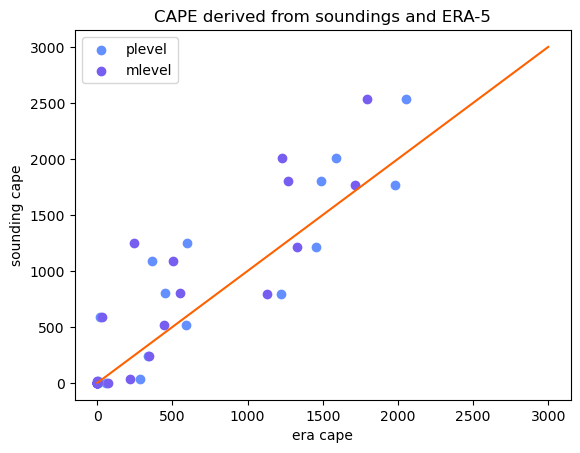

In [8]:

plt.scatter(soundings.era_cape_plevel.fillna(0),soundings.cape.fillna(0),alpha=1,c=c1,label='plevel')
plt.scatter(soundings.era_cape_mlevel.fillna(0),soundings.cape.fillna(0),alpha=1,c=c2,label='mlevel')
plt.xlabel('era cape')
plt.ylabel('sounding cape')
plt.legend()
plt.plot(np.arange(3000),np.arange(3000),c=c4)
plt.title('CAPE derived from soundings and ERA-5')
plt.savefig(figpath+'cape_soundings.png')
plt.show()

In [47]:
import matplotlib.colors as colors
import matplotlib
#-- Color schemes
cmap = colors.LinearSegmentedColormap.from_list('mycmap', [c1,c2,c3,c4,c5])
matplotlib.cm.register_cmap("mycolormap3", cmap)

/tmp/ipykernel_532690/1180752591.py:5: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("mycolormap3", cmap)


In [11]:


data = {'cape era': pd.concat([soundings.era_cape_plevel,soundings.era_cape_mlevel],axis=0,ignore_index=True),
        'cape sounding': pd.concat([soundings.cape, soundings.cape],axis=0,ignore_index=True),
        'label': np.append(np.ones(len(soundings)),(2*np.ones(len(soundings))) )}

sset=pd.DataFrame(data)
sset.label[sset.label==1]='plevel'
sset.label[sset.label==2]='mlevel'


/tmp/ipykernel_676916/4085975782.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'plevel' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  sset.label[sset.label==1]='plevel'


In [ ]:

print('making kde-plot')
g=sns.jointplot(data=sset, x='cape era', y='cape sounding', kind='kde', hue='label', palette=[c1,c3],
                levels=np.arange(0,1.1,0.1), xlim=(0,3200), ylim=(0,3200) ) #, fill=True, alpha=0.6,
g.ax_joint.plot([0,3500], [0,3500], 'k--', linewidth = 1)
print('formatting kdeplot')

# g.ax_joint.set_xlabel('0-6km shear [m s$^{-1}$]')
# g.ax_joint.set_ylabel('CAPE [J kg$^{-1}$]')
g.savefig(figpath+'sound_comp_kde.png')

In [9]:
latslice=slice(27,40);lonslice =slice(260,285)
conv_era5=xr.open_dataset(savepath+flag+'_init_convseason_2020.nc').sortby('latitude').fillna(0)
conv_era5=conv_era5.sel(time=conv_era5.time.dt.year.isin([year]))
conv_era5=conv_era5.sel(time=conv_era5.time.dt.month.isin([month]))#np.arange(3,10)))
conv_era5=conv_era5.sel(time=conv_era5.time.dt.day.isin([day]),latitude=latslice,longitude=lonslice)
dp2 = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/case_2020_USAtor/'
era_mod_cape=xr.open_dataset(dp2+'USA_tor_2020_cape_era5.nc').sortby('latitude').fillna(0)
era_mod_cape.coords['longitude'] = (era_mod_cape.coords['longitude'] % 360)
era_mod_cape=era_mod_cape.sel(time=era_mod_cape.time.dt.year.isin([year]))
era_mod_cape=era_mod_cape.sel(time=era_mod_cape.time.dt.month.isin([month]))#np.arange(3,10)))
era_mod_cape=era_mod_cape.sel(time=era_mod_cape.time.dt.day.isin([day]),latitude=latslice,longitude=lonslice)

<xarray.DataArray 'longitude' (longitude: 201)>
array([-110.  , -109.75, -109.5 , ...,  -60.5 ,  -60.25,  -60.  ],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -110.0 -109.8 -109.5 ... -60.5 -60.25 -60.0
Attributes:
    units:      degrees_east
    long_name:  longitude
<xarray.DataArray 'longitude' (longitude: 201)>
array([250.  , 250.25, 250.5 , ..., 299.5 , 299.75, 300.  ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 250.0 250.2 250.5 250.8 ... 299.5 299.8 300.0


making plot


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim'
  cset = contour_func(
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim'
  cset = contour_func(


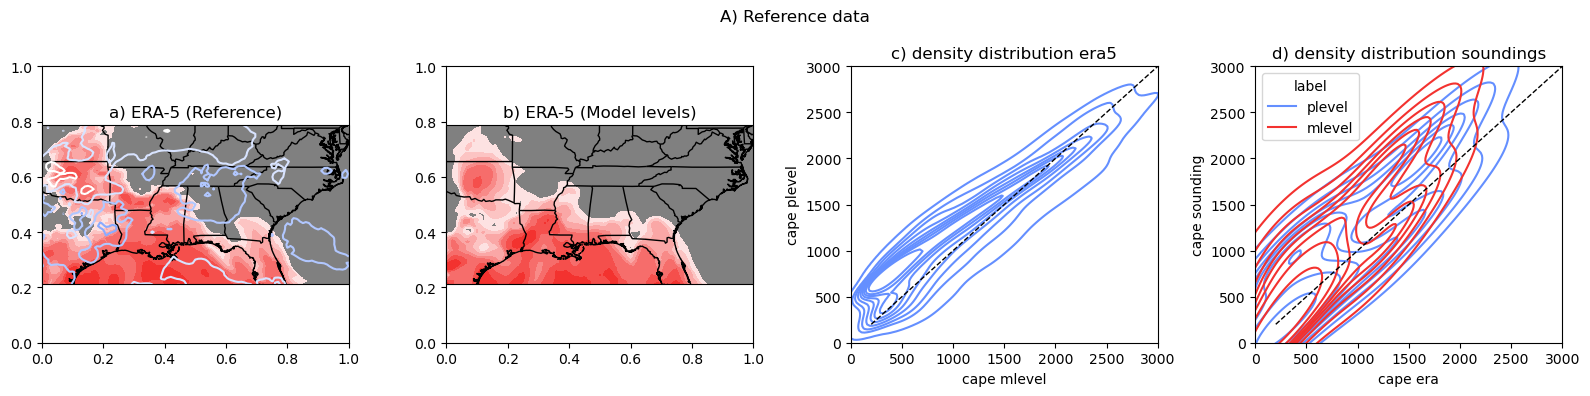

In [32]:
###READ FORECAST AT LEADTIME 1 DAY
import cartopy.feature as cfeature
date='2020041200'
ii=1
pangu=xr.open_dataset(savepath+flag+'_conv_pangu-oper_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
graphcast=xr.open_dataset(savepath+flag+'_conv_graphcast-oper_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
fourcastnet=xr.open_dataset(savepath+flag+'_conv_sfno-oper_'+date+'00.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
ifs=xr.open_dataset(savepath+flag+'_conv_ifs_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii+1).sel(latitude=latslice,longitude=lonslice)
era5=conv_era5.sel(time=pangu.time.values+pangu.prediction_timedelta.values)
era5_ml=era_mod_cape.sel(time=pangu.time.values+pangu.prediction_timedelta.values)
###CAPE PLOT
cm= colors.LinearSegmentedColormap.from_list('mycmap', ['#FFFFFF', '#f3322f'])#'#dc267f'])  
cm.set_under(color="grey")
cm.set_bad(color="grey")
cmd = colors.LinearSegmentedColormap.from_list('mycmap', [ '#FFFFFF','#648fff'])  
cmd2 = colors.LinearSegmentedColormap.from_list('mycmap', ['#648fff', '#FFFFFF', '#f3322f'])#'#dc267f'])  
cmd3 = colors.LinearSegmentedColormap.from_list('mycmap', ['#785ef0', '#808080', '#ffb000'])#'#fe6100'])   
print('making plot')
n=0
projection = ccrs.PlateCarree()

fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,4))

ax1 = plt.subplot(1, 4, 1, projection=ccrs.PlateCarree())
line_plot=era5.bs_06.plot.contourf(transform=projection, x='longitude', y='latitude',ax=ax1,
         cmap=cmd,vmin=5,vmax=51,levels=[10,20,30,40,50],extend='both', add_colorbar=False)
contour_plot=era5.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=ax1,
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
era5.bs_06.plot.contour(transform=projection, x='longitude', y='latitude',ax=ax1,
          cmap=cmd,vmin=5,vmax=51,levels=[10,20,30,40,50],extend='both')

ax1.coastlines()
ax1.set_title('') # to supress xarray auto-title
ax1.set_title('a) ERA-5 (Reference)')
ax1.add_feature(cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines', '110m',
    edgecolor='black', facecolor='none'))

ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)


ax2 = plt.subplot(1, 4, 2, projection=ccrs.PlateCarree())
era5_ml.cape.plot.contourf(transform=projection, x='longitude', y='latitude',ax=ax2,
        cmap=cm,vmin=100,vmax=2000,levels=[100,300,500,800,1000,1500,2000],extend='both', add_colorbar=False)
ax2.coastlines()
ax2.set_title('') # to supress xarray auto-title
ax2.set_title('b) ERA-5 (Model levels)')
ax2.add_feature(cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines', '110m',
    edgecolor='black', facecolor='none'))
#ax2.spines.set_visible(False)


sns.kdeplot(data=dset, x="cape mlevel", y="cape plevel", color = '#648fff',
                         xlim=(0,3000), ylim=(0,3000), ax=ax3 )#levels=np.arange(0,1.1,0.1),, fill=True, alpha = 0.7
ax3.plot([200,3000], [200,3000], c='k', linewidth = 1, linestyle = '--')
ax3.set_xlim([0,3000])
ax3.set_ylim([0,3000])
ax3.set_title('c) density distribution era5')

sns.kdeplot(data=sset, x='cape era', y='cape sounding', hue='label', palette=['#648fff','#f3322f'],
                levels=np.arange(0,1.1,0.1), xlim=(0,3200), ylim=(0,3200), ax=ax4  ) #, fill=True, alpha=0.6,
ax4.plot([200,3000], [200,3000], c='k', linewidth = 1, linestyle = '--')
ax4.set_xlim([0,3000])
ax4.set_ylim([0,3000])
ax4.set_title('d) density distribution soundings')

# cbar = fig.colorbar(contour_plot, ax=axes, orientation='horizontal',ticks=[100,300,500,800,1000,1500,2000])
# cbar.set_label('CAPE [J kg$^{-1}$]')
# cbar = fig.colorbar(line_plot, ax=axes, orientation='horizontal',ticks=[10,20,30,40,50])
# cbar.set_label('DLS [m s$^{-1}$]')
fig.suptitle('A) Reference data')
plt.tight_layout()
fig.savefig(figpath+'cape_reference_case.png',  dpi=300, bbox_inches='tight')

In [37]:
np.corrcoef(era5.cape.values.flatten(),era5_ml.cape.values.flatten())

array([[1.        , 0.88932329],
       [0.88932329, 1.        ]])

making plot


/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim'
  cset = contour_func(
/work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim'
  cset = contour_func(
/tmp/ipykernel_532690/1366859893.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


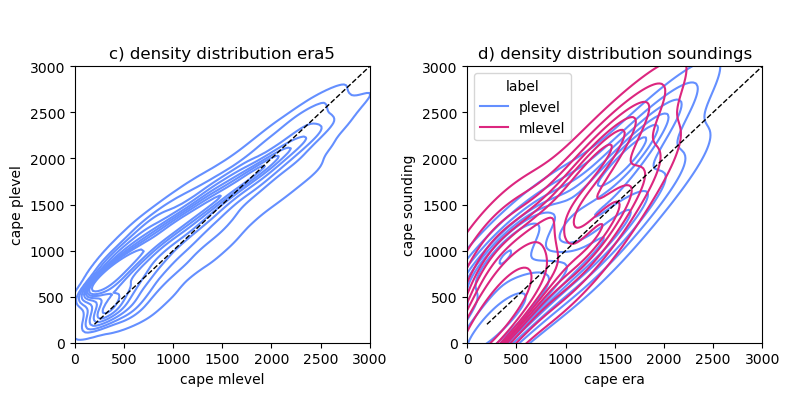

In [59]:
###READ FORECAST AT LEADTIME 1 DAY
import cartopy.feature as cfeature
date='2020041200'
ii=1
pangu=xr.open_dataset(savepath+flag+'_conv_pangu-oper_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
graphcast=xr.open_dataset(savepath+flag+'_conv_graphcast-oper_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
fourcastnet=xr.open_dataset(savepath+flag+'_conv_sfno-oper_'+date+'00.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii).sel(latitude=latslice,longitude=lonslice)
ifs=xr.open_dataset(savepath+flag+'_conv_ifs_'+date+'.nc').sortby('latitude').fillna(0).isel(prediction_timedelta=ii+1).sel(latitude=latslice,longitude=lonslice)
era5=conv_era5.sel(time=pangu.time.values+pangu.prediction_timedelta.values)
era5_ml=era_mod_cape.sel(time=pangu.time.values+pangu.prediction_timedelta.values)
###CAPE PLOT
cm= colors.LinearSegmentedColormap.from_list('mycmap', ['#FFFFFF', '#f3322f'])#'#dc267f'])  
cm.set_under(color="grey")
cm.set_bad(color="grey")
cmd = colors.LinearSegmentedColormap.from_list('mycmap', [ '#FFFFFF','#648fff'])  
cmd2 = colors.LinearSegmentedColormap.from_list('mycmap', ['#648fff', '#FFFFFF', '#f3322f'])#'#dc267f'])  
cmd3 = colors.LinearSegmentedColormap.from_list('mycmap', ['#785ef0', '#808080', '#ffb000'])#'#fe6100'])   
print('making plot')
n=0
projection = ccrs.PlateCarree()
#era_ref=era_ref.assign(mean_sea_level_pressure=lambda era_ref: xr_era5.mean_sea_level_pressure)
fig,axes = plt.subplots(1,2,figsize=(8,4), layout='compressed')


sns.kdeplot(data=dset, x="cape mlevel", y="cape plevel", color = c1,
                         xlim=(0,3000), ylim=(0,3000), ax=axes[0] )#levels=np.arange(0,1.1,0.1),, fill=True, alpha = 0.7
axes[0].plot([200,3000], [200,3000], c='k', linewidth = 1, linestyle = '--')
axes[0].set_xlim([0,3000])
axes[0].set_ylim([0,3000])
axes[0].set_title('c) density distribution era5')

sns.kdeplot(data=sset, x='cape era', y='cape sounding', hue='label', palette=[c1,c3],
                levels=np.arange(0,1.1,0.1), xlim=(0,3200), ylim=(0,3200), ax=axes[1]  ) #, fill=True, alpha=0.6,
axes[1].plot([200,3000], [200,3000], c='k', linewidth = 1, linestyle = '--')
axes[1].set_xlim([0,3000])
axes[1].set_ylim([0,3000])
axes[1].set_title('d) density distribution soundings')




# cbar = fig.colorbar(contour_plot, ax=axes, orientation='horizontal',ticks=[100,300,500,800,1000,1500,2000])
# cbar.set_label('CAPE [J kg$^{-1}$]')
# cbar = fig.colorbar(line_plot, ax=axes, orientation='horizontal',ticks=[10,20,30,40,50])
# cbar.set_label('DLS [m s$^{-1}$]')
fig.suptitle(' ')
plt.tight_layout()
fig.savefig(figpath+'cape_sounding.png',  dpi=300, bbox_inches='tight')

In [27]:
stnames=['LAKE_CHARLES','JACKSON','SHREVEPORT','SLIDELL','BIRMINGHAM','FORT_WORTH']
from metpy.calc import specific_humidity_from_dewpoint
from metpy.units import units

fillen = len(glob(soundpath+'*'))
fill = {'station': np.zeros(fillen),
        'date_time': np.zeros(fillen),
        'lat': np.zeros(fillen),
        'lon': np.zeros(fillen),
        'height': np.zeros(fillen),
        'cape': np.zeros(fillen),
        'cin': np.zeros(fillen),
        'lcl': np.zeros(fillen),
        'lfc': np.zeros(fillen),
        'era_cape_mlevel': np.zeros(fillen),
        'era_cape_plevel': np.zeros(fillen)}

soundings=pd.DataFrame(fill)
a=0
b=0
for stname in stnames[:]:
    files=sorted(glob(soundpath+stname+'*'))
    for file in files[:]:
        data = pd.read_csv(file,sep=';')
        data = data.sort_values(by='pressure',ascending=True)
        soundings.station[a]=stname
        soundings.date_time[a]=data.time.values[0]
        soundings.lat[a]=data.latitude.values[0]
        soundings.lon[a]=data.longitude.values[0]
        soundings.height[a]=data.elevation.values[0]

        data['spec_hum']=specific_humidity_from_dewpoint(pressure=(data.pressure.values * units.hPa), dewpoint=(data.dewpoint.values * units.degC)).magnitude

        sound_inst=wrf.cape_2d(pres_hpa=data.pressure.values, tkel=data.temperature.values+273.3, qv=data.spec_hum.values, height=data.height.values, terrain=data.elevation.values[0], psfc_hpa=data.pressure.values[0], ter_follow=False)
        print(sound_inst)
        soundings.cape[a]=sound_inst[0].values
        soundings.cin[a]=sound_inst[1].values
        soundings.lcl[a]=sound_inst[2].values
        soundings.lfc[a]=sound_inst[3].values

        c = (a - (4*(b)))*2
        ilat1 = np.argmin(abs(era_ref.latitude.values - data.latitude.values[0]))
        ilon1 = np.argmin(abs(era_ref.longitude.values - data.longitude.values[0] - 360))
        ilat2 = np.argmin(abs(era_mod_cape.latitude.values - data.latitude.values[0]))
        ilon2 = np.argmin(abs(era_mod_cape.longitude.values - data.longitude.values[0]))
        soundings.era_cape_mlevel[a]=era_ref.cape[c,ilat1,ilon1].values
        soundings.era_cape_plevel[a]=era_mod_cape.cape[c,ilat2,ilon2].values
        
        a+=1
    b+=1
    print(c,ilat2,ilon2)

        

<xarray.Dataset>
Dimensions:    (latitude: 53, longitude: 101)
Coordinates:
  * latitude   (latitude) float32 27.0 27.25 27.5 27.75 ... 39.5 39.75 40.0
    time       datetime64[ns] 2020-04-12T12:00:00
  * longitude  (longitude) float32 260.0 260.2 260.5 260.8 ... 284.5 284.8 285.0
Data variables:
    cape       (latitude, longitude) float32 2.21e+03 1.889e+03 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-28 17:42:59 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...